# Table of Contents

1. [Data Import & Manipulation](#1.-Data-Import-&-Manipulation) 
    1. [Fuel Output & Demand Data](#A.-Fuel-Output-&-Demand-Data)
    2. [HOEP Data](#B.-HOEP-Data)
    3. [NG Production & Demand Data](#C.-NG-Production-&-Demand-Data)
    4. [Transportation Demand Data](#D.-Transportation-Demand-Data)
    5. [Industry Demand Data](#E.-Industry-Demand-Data)
    6. [Input-Data-to-MILP](#F.-Input-Data-to-MILP)
2. [Mixed Integer Linear Programming](#2.-Mixed-Integer-Linear-Programming)

# Libraries

In [82]:
import pandas as pd

# Variables 

In [94]:
raw=pd.read_csv('Variables.csv')
raw2=raw.dropna(axis='columns',how='all')
var=raw2.dropna(axis='rows',how='all')
var.set_index("variable_name",inplace=True)

In [95]:
var.head()

,value,unit,source,comment
variable_name,,,,
electrolyzer_eff,0.7667,dimensionless,eqtn 3.1,NaN
E_hhv_h2,3.5500,kWh/m^3 H2,eqtn 3.1,NaN
E_rated_h2,4.6300,kWh/m^3 H2,eqtn 3.1,NaN
min_E_cap,0.0000,kWh,eqtn 3.3,NaN
max_E_cap,1000.0000,kWh,eqtn 3.3,NaN


# 1. Data Import & Manipuation

## A. Fuel Output & Demand Data

Fuel output by sources (i.e. nuclear, gas, hydro)

In [3]:
fuel_output = pd.read_csv('on_fuel_source_output_2017.csv', keep_default_na=False, na_values=[""])

Fuel demand in Onatrio 

In [4]:
fuel_demand = pd.read_csv('on_demand_2017.csv', keep_default_na=False, na_values=[""])

In [5]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,1,NUCLEAR,11592
1,2017-01-01,1,GAS,234
2,2017-01-01,1,HYDRO,2455
3,2017-01-01,1,WIND,2433
4,2017-01-01,1,SOLAR,0


subtract 1 hour because we want 0 to 23 hr 

In [6]:
fuel_output['Hour'] = fuel_output['Hour'] - 1

In [7]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,0,NUCLEAR,11592
1,2017-01-01,0,GAS,234
2,2017-01-01,0,HYDRO,2455
3,2017-01-01,0,WIND,2433
4,2017-01-01,0,SOLAR,0


In [8]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,1,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,2,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,3,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,4,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,5,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


In [9]:
fuel_demand['Hour'] = fuel_demand['Hour'] -1

In [10]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create Datetime columns in both df

In [11]:
fuel_output['Datetime'] = pd.to_datetime(fuel_output['Date']) + pd.to_timedelta(fuel_output['Hour'], unit='h')

In [12]:
fuel_output.head()

,Date,Hour,Fuel,Output,Datetime
0,2017-01-01,0,NUCLEAR,11592,2017-01-01
1,2017-01-01,0,GAS,234,2017-01-01
2,2017-01-01,0,HYDRO,2455,2017-01-01
3,2017-01-01,0,WIND,2433,2017-01-01
4,2017-01-01,0,SOLAR,0,2017-01-01


In [13]:
fuel_demand['Datetime'] = pd.to_datetime(fuel_demand['Date']) + pd.to_timedelta(fuel_demand['Hour'], unit='h')

In [14]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Datetime
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268",2017-01-01 00:00:00
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673",2017-01-01 01:00:00
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974",2017-01-01 02:00:00
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186",2017-01-01 03:00:00
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227",2017-01-01 04:00:00


Groupby Datetime

In [15]:
fuel_output_total = pd.DataFrame(fuel_output.groupby('Datetime')['Output'].sum())
fuel_output_total.columns = ['fuel_total']

In [16]:
fuel_output_total.head()

,fuel_total
Datetime,
2017-01-01 00:00:00,16715
2017-01-01 01:00:00,16344
2017-01-01 02:00:00,15942
2017-01-01 03:00:00,15727
2017-01-01 04:00:00,15653


Set index using Datetime

In [17]:
fuel_demand.set_index('Datetime',inplace=True)

In [18]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
2017-01-01 01:00:00,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2017-01-01 02:00:00,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
2017-01-01 03:00:00,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
2017-01-01 04:00:00,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create SBG data by joining the two data and taking the difference

In [19]:
SBG = pd.merge(fuel_output_total[['fuel_total']],fuel_demand[['Ontario Demand']], how='inner',left_index=True, right_index=True)

In [20]:
SBG.head()

,fuel_total,Ontario Demand
Datetime,,
2017-01-01 00:00:00,16715,13522
2017-01-01 01:00:00,16344,13117
2017-01-01 02:00:00,15942,12816
2017-01-01 03:00:00,15727,12605
2017-01-01 04:00:00,15653,12563


In [21]:
SBG['Difference'] = SBG['fuel_total'] - SBG['Ontario Demand']

In [22]:
SBG.head()

,fuel_total,Ontario Demand,Difference
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193
2017-01-01 01:00:00,16344,13117,3227
2017-01-01 02:00:00,15942,12816,3126
2017-01-01 03:00:00,15727,12605,3122
2017-01-01 04:00:00,15653,12563,3090


Check if there's any cell with difference less than 0

In [23]:
SBG[SBG['Difference']<0].count()

fuel_total        697
Ontario Demand    697
Difference        697
dtype: int64

Assign negative numbers with 0's 

In [24]:
SBG.loc[SBG['Difference']<=0,'Difference'] = 0

In [25]:
SBG[SBG['Difference']<0].count()

fuel_total        0
Ontario Demand    0
Difference        0
dtype: int64

Convert SBG MWh to KWh

In [26]:
SBG['Difference'] = SBG['Difference']*1000

Export the SBG data to a csv file

In [27]:
SBG.columns = ['fuel_output','fuel_demand','SBG(kWh)']

In [28]:
SBG.head()

,fuel_output,fuel_demand,SBG(kWh)
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193000
2017-01-01 01:00:00,16344,13117,3227000
2017-01-01 02:00:00,15942,12816,3126000
2017-01-01 03:00:00,15727,12605,3122000
2017-01-01 04:00:00,15653,12563,3090000


## B. HOEP Data

HOEP values are reported as $/Mwh

In [29]:
hoep_data = pd.read_csv('HOEP_2017.csv', keep_default_na=False, na_values=[""])

In [30]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2017-01-01,1,0.0,5.94,0.0,0.0,NaN,NaN,NaN
1,2017-01-01,2,0.0,0.00,2.2,0.0,NaN,NaN,NaN
2,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN
3,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN
4,2017-01-01,5,0.0,0.00,0.0,0.0,NaN,NaN,NaN


In [31]:
hoep_data['Hour'] = hoep_data['Hour'] -1

In [32]:
hoep_data['Datetime'] = pd.to_datetime(hoep_data['Date']) + pd.to_timedelta(hoep_data['Hour'], unit='h')

In [33]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,Datetime
0,2017-01-01,0,0.0,5.94,0.0,0.0,NaN,NaN,NaN,2017-01-01 00:00:00
1,2017-01-01,1,0.0,0.00,2.2,0.0,NaN,NaN,NaN,2017-01-01 01:00:00
2,2017-01-01,2,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 02:00:00
3,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 03:00:00
4,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 04:00:00


In [34]:
hoep_data.set_index('Datetime',inplace=True)

In [35]:
hoep_data.head(10)

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
Datetime,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,0.00,5.94,0.00,0.00,NaN,NaN,NaN
2017-01-01 01:00:00,2017-01-01,1,0.00,0.00,2.20,0.00,NaN,NaN,NaN
2017-01-01 02:00:00,2017-01-01,2,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 03:00:00,2017-01-01,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 04:00:00,2017-01-01,4,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 05:00:00,2017-01-01,5,0.00,0.01,0.00,1.99,NaN,NaN,NaN
2017-01-01 06:00:00,2017-01-01,6,0.00,5.94,6.04,6.02,NaN,NaN,NaN
2017-01-01 07:00:00,2017-01-01,7,1.71,6.74,8.42,6.74,NaN,NaN,NaN
2017-01-01 08:00:00,2017-01-01,8,0.00,5.74,5.70,5.84,NaN,NaN,NaN


HOEP data is dollar/Mwh so need to convert to dollar/kWh

In [36]:
hoep_data['HOEP']= hoep_data['HOEP']/1000

In [37]:
input_df = pd.merge(SBG[['SBG(kWh)']],hoep_data[['HOEP']], how='inner',left_index=True, right_index=True)

In [38]:
input_df.head(10)

,SBG(kWh),HOEP
Datetime,,
2017-01-01 00:00:00,3193000,0.00000
2017-01-01 01:00:00,3227000,0.00000
2017-01-01 02:00:00,3126000,0.00000
2017-01-01 03:00:00,3122000,0.00000
2017-01-01 04:00:00,3090000,0.00000
2017-01-01 05:00:00,2898000,0.00000
2017-01-01 06:00:00,2739000,0.00000
2017-01-01 07:00:00,2726000,0.00171
2017-01-01 08:00:00,2267000,0.00000


## C. NG Production & Demand Data

In [39]:
NG_hourly_distribution = pd.read_csv('NG_hourly_distribution.csv')

In [40]:
NG_hourly_distribution.head()

,hour,hourly_distribution
0,1,105
1,2,100
2,3,95
3,4,95
4,5,100


In [41]:
NG_hourly_distribution['ratio'] = NG_hourly_distribution['hourly_distribution']/sum(NG_hourly_distribution['hourly_distribution'])

In [42]:
NG_hourly_distribution['hour'] = NG_hourly_distribution['hour']-1

In [43]:
NG_hourly_distribution.head()

,hour,hourly_distribution,ratio
0,0,105,0.033113
1,1,100,0.031536
2,2,95,0.029959
3,3,95,0.029959
4,4,100,0.031536


In [44]:
NG_monthly_production = pd.read_csv('NG_monthly_production.csv')

In [45]:
NG_monthly_production.head()

,month,NG_production(e3m3/d)
0,1,6184
1,2,6165
2,3,6168
3,4,5978
4,5,6170


In [46]:
input_df['NG_demand(m^3)'] = 0
input_df['NG_demand(m^3)'] = input_df['NG_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,0.0
2017-01-01 01:00:00,3227000,0.0,0.0
2017-01-01 02:00:00,3126000,0.0,0.0
2017-01-01 03:00:00,3122000,0.0,0.0
2017-01-01 04:00:00,3090000,0.0,0.0


NG demand calculation

In [47]:
for index, row in input_df.iterrows():
   
    curr_hour = index.hour
    curr_month = index.month 
    ratio = NG_hourly_distribution[NG_hourly_distribution['hour']==curr_hour]['ratio'].iloc[0]
    NG_prod = NG_monthly_production[NG_monthly_production['month']==curr_month]['NG_production(e3m3/d)'].iloc[0]
  
    input_df.loc[index,'NG_demand(m^3)'] = (ratio * NG_prod).round(3)*1000
    

In [48]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,204768.0
2017-01-01 01:00:00,3227000,0.0,195017.0
2017-01-01 02:00:00,3126000,0.0,185266.0
2017-01-01 03:00:00,3122000,0.0,185266.0
2017-01-01 04:00:00,3090000,0.0,195017.0


In [49]:
input_df.reset_index(inplace=True)

In [50]:
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0
1,2017-01-01 01:00:00,3227000,0.00000,195017.0
2,2017-01-01 02:00:00,3126000,0.00000,185266.0
3,2017-01-01 03:00:00,3122000,0.00000,185266.0
4,2017-01-01 04:00:00,3090000,0.00000,195017.0
5,2017-01-01 05:00:00,2898000,0.00000,214519.0
6,2017-01-01 06:00:00,2739000,0.00000,273024.0
7,2017-01-01 07:00:00,2726000,0.00171,282775.0
8,2017-01-01 08:00:00,2267000,0.00000,243772.0
9,2017-01-01 09:00:00,2324000,0.00000,234021.0


## D. Transportation Demand Data

## E. Industry Demand Data

## F. Input Data to MILP

# 2. Mixed Integer Linear Programming

In [96]:
"""
Model for RNG/NG + HENG
"""

import pulp
import pandas as pd

# Time-series constants
SBG = list(input_df['SBG(kWh)'])
D = list(input_df['NG_demand(m^3)'])
HOEP = list(input_df['HOEP'])

# Fixed constants
nu_electrolyzer = var['value']['electrolyzer_eff']
E_HHV_H2 = var['value']['E_hhv_h2']
nu_reactor = var['value']['meth_reactor_eff']
HHV_H2 = var['value']['HHV_H2']
HHV_NG = var['value']['HHV_NG']
CO2_available = var['value']['CO2_available']
E_electrolyzer_min = var['value']['min_E_cap']
E_electrolyzer_max = var['value']['max_E_cap']
tau = 0.50
beta = var['value']['beta']
C_0 = var['value']['C_0']
mu = var['value']['mu']
gamma = var['value']['gamma']
k = var['value']['k']
C_upgrading = var['value']['C_upgrading']
C_CO2 = var['value']['C_CO2']
TC = var['value']['TC']
C_H2O = var['value']['C_H2O']
WCR = var['value']['water_cons_rate']
OPEX_upgrading = var['value']['OPEX_upgrading']

# RNG + HENG model
LP = pulp.LpProblem('LP', pulp.LpMinimize)

# RNG Variables
RNG_max = pulp.LpVariable('RNG_max',
                          lowBound=0,
                          cat='Continuous')
N_electrolyzer_1 = pulp.LpVariable('N_electrolyzer_1',
                                 lowBound=0,
                                 cat='Continuous')
alpha_1 = pulp.LpVariable.dicts('alpha_1',
                          [str(i) for i in range(1, 31)],
                          cat='Binary')
E_1 = pulp.LpVariable.dicts('E_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
H2_1 = pulp.LpVariable.dicts('H2_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
RNG = pulp.LpVariable.dicts('RNG',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
CO2 = pulp.LpVariable.dicts('CO2_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
CAPEX_1 = pulp.LpVariable('CAPEX_1', lowBound=0, cat='Continuous')
OPEX_1 = pulp.LpVariable('OPEX_1', lowBound=0, cat='Continuous')

# HENG Variables
N_electrolyzer_2 = pulp.LpVariable('N_electrolyzer_2',
                                 lowBound=0,
                                 cat='Continuous')
alpha_2 = pulp.LpVariable.dicts('alpha_2',
                          [str(i) for i in range(1, 31)],
                          cat='Binary')
E_2 = pulp.LpVariable.dicts('E_2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
H2_2 = pulp.LpVariable.dicts('H2_2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
CO2 = pulp.LpVariable.dicts('CO2_2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
CAPEX_2 = pulp.LpVariable('CAPEX_2', cat='Continuous')
OPEX_2 = pulp.LpVariable('OPEX_2', cat='Continuous')

# Shared Variables
NG = pulp.LpVariable.dicts('NG',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

for i, h in enumerate([str(i) for i in input_df.index]):
    # Energy and flow constraints
    LP += H2_1[h] + H2_2[h] == nu_electrolyzer * (E_1[h] + E_2[h]) / E_HHV_H2

    if h == '0':
        LP += RNG_max <= CO2_available
    LP += RNG[h] == nu_reactor * H2_1[h] * HHV_H2 / HHV_NG
    LP += CO2[h] == RNG[h]

    # Demand constraint
    LP += D[i] == RNG[h] + NG[h] + H2_2[h]

    # Supply constraint
    LP += E_1[h] + E_2[h] <= SBG[i]

    # Electrolyzer constraints
    LP += N_electrolyzer_1 * E_electrolyzer_min <= E_1[h]
    LP += N_electrolyzer_1 * E_electrolyzer_max >= E_1[h]
    LP += N_electrolyzer_2 * E_electrolyzer_min <= E_2[h]
    LP += N_electrolyzer_2 * E_electrolyzer_max >= E_2[h]

    # Reactor constraints
    LP += RNG[h] <= RNG_max
    if h != '0':
        LP += -RNG_max * tau <= RNG[h] - RNG[str(i - 1)]
        LP += RNG_max * tau >= RNG[h] - RNG[str(i - 1)]

    # HENG-specific constraints
    LP += 0.95 * H2_2[h] <= 0.05 * (NG[h] + RNG[h])

    # Integer constraints
    if h == '0':
        LP += pulp.lpSum(n * alpha_1[str(n)] for n in range(1, 31)) == N_electrolyzer_1
        LP += pulp.lpSum(alpha_1) <= 1
        LP += pulp.lpSum(n * alpha_2[str(n)] for n in range(1, 31)) == N_electrolyzer_2
        LP += pulp.lpSum(alpha_2) <= 1

# Electrolyzer cost
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, 31)]

# CAPEX RNG
LP += pulp.lpSum(alpha_1[str(n)] * C_electrolyzer[n - 1] for n in range(1, 31)) + \
      gamma * RNG_max + k + C_upgrading * RNG_max == CAPEX_1

# CAPEX HENG
LP += pulp.lpSum(alpha_2[str(n)] * C_electrolyzer[n - 1] for n in range(1, 31)) == CAPEX_2

# OPEX RNG
LP += pulp.lpSum(CO2[str(n)] * C_CO2 for n in input_df.index) + \
      pulp.lpSum(E_1[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
      pulp.lpSum(H2_1[str(n)] * C_H2O * WCR for n in input_df.index) + \
      OPEX_upgrading * RNG_max == OPEX_1

# OPEX HENG
LP += pulp.lpSum(E_2[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
      pulp.lpSum(H2_2[str(n)] * C_H2O * WCR for n in input_df.index) == OPEX_2

    
# Objective
LP += CAPEX_1 + CAPEX_2 + OPEX_1 + OPEX_2, 'Z'

LP.solve()
print([x.varValue for x in LP.variables()])
print(pulp.value(LP.objective))


[2000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [97]:
print(LP.status)
print(RNG_max.value())
print(N_electrolyzer.value())
print(CAPEX.value(), OPEX.value())

1
0.0
3502.0
578664920.0 336212210.0


In [90]:
"""
Model for RNG/NG
"""

import pulp
import pandas as pd

# Time-series constants
SBG = list(input_df['SBG(kWh)'])
D = list(input_df['NG_demand(m^3)'])
HOEP = list(input_df['HOEP'])

#count number of non-zero SBG hours
non_zero_SBG_hrs = sum(x > 0 for x in SBG)

# Fixed constants
nu_electrolyzer = 3.55 / 4.63 #dimensionless
E_HHV_H2 = 3.55 #kWh/m^3 H2
nu_reactor = 213.6 / 4 / 68.7 #dimensionless 

HHV_H2 = 0.2718 #MMBtu/kmol pdf page 181
HHV_NG = 0.8053 #MMBtu/kmol pdf page 181 

#temporarily disabled these 
#HHV_H2 = 68.7 
#HHV_NG = 10.55 #0.03623 MMBtu/m^3 & 293.2972222kWh/1MMBtu  = [kwh/m^3]


CO2_available = 6246451/non_zero_SBG_hrs # m^3/h during non-zero SBG hours 
E_electrolyzer_min = 0 # kWh
E_electrolyzer_max = 1000 # kwh
tau = 0.50 # ramp rate limitation 
beta = 1.35 # replacement and captial cost factor 
C_0 = 1324.3 # $/kW
mu = 0.707 # scaling factor 
gamma = 1714.8 # $/m^3
k = 2e6 # $
C_upgrading = 1172.3 # $/m^3
C_CO2 = 0.172 # $/m^3
TC = 0.008804 # $/kWh
C_H2O = 0.00314 # $/L H2O
WCR = 0.4 # L/m^3 H2
OPEX_upgrading = 146.5 #$/m^3


# MILP model - Cost minimization model 
LP = pulp.LpProblem('LP', pulp.LpMinimize)


# MILP variables 
RNG_max = pulp.LpVariable('RNG_max',
                          lowBound=0,
                          cat='Continuous') # m^3/h 

N_electrolyzer = pulp.LpVariable('N_electrolyzer',
                                 lowBound=0,
                                 cat='Integer') # dimensionless 

alpha = pulp.LpVariable.dicts('alpha',
                          [str(i) for i in range(1, 31)],
                          cat='Binary') # dimensionless 

E = pulp.LpVariable.dicts('E_h',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous') # kWh


H2 = pulp.LpVariable.dicts('H2_h',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous') # m^3/h 

RNG = pulp.LpVariable.dicts('RNG_h',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous') # m^3/h 

CO2 = pulp.LpVariable.dicts('CO2_h',
                          [str(i) for i in input_df.index],
                          lowBound=0, 
                          cat='Continuous') # m^3/h


NG = pulp.LpVariable.dicts('NG_h',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous') # m^3/h 

# Objective variables 
CAPEX = pulp.LpVariable('CAPEX', cat='Continuous')
OPEX = pulp.LpVariable('OPEX', cat='Continuous')


for i, h in enumerate([str(i) for i in input_df.index]):
    # Energy and flow constraints

    if h == '0':
        LP += RNG_max <= CO2_available
    LP += H2[h] == nu_electrolyzer * E[h] / E_HHV_H2
    LP += RNG[h] == nu_reactor * H2[h] * HHV_H2 / HHV_NG
    LP += CO2[h] == RNG[h]

    # Demand constraint
    LP += NG[h] == D[i] - RNG[h]
    #LP += RNG[h] == D[i]
    
    # Electrolyzer and reactor constraints
    LP += N_electrolyzer * E_electrolyzer_min <= E[h]
    LP += N_electrolyzer * E_electrolyzer_max >= E[h]
    LP += E[h] <= SBG[i]
    LP += RNG[h] <= RNG_max
    if h != '0':
        LP += -RNG_max * tau <= RNG[h] - RNG[str(i - 1)]
        LP += RNG_max * tau >= RNG[h] - RNG[str(i - 1)]
    if h == '0':
        LP += pulp.lpSum(n * alpha[str(n)] for n in range(1, 31)) == N_electrolyzer
        LP += pulp.lpSum(alpha) == 1

# CAPEX
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, 31)]
LP += pulp.lpSum(alpha[str(n)] * C_electrolyzer[n - 1] for n in range(1, 31)) + \
      gamma * RNG_max + k + C_upgrading * RNG_max == CAPEX

# OPEX
LP += pulp.lpSum(CO2[str(n)] * C_CO2 for n in input_df.index) + \
      pulp.lpSum(E[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
      pulp.lpSum(H2[str(n)] * C_H2O * WCR for n in input_df.index) + \
      OPEX_upgrading * RNG_max == OPEX

# Objective
LP += CAPEX + OPEX, 'Z'

LP.solve()
print([x.varValue for x in LP.variables()])
print(pulp.value(LP.objective))

[578664920.0, 180923.18, 182849.7, 135366.57, 134120.0, 9519.2901, 0.0, 0.0, 0.0, 0.0, 7989.4042, 18471.956, 44819.991, 44480.016, 76664.283, 120011.05, 103862.25, 103522.28, 117064.6, 107431.99, 83407.114, 59438.901, 74907.747, 63008.635, 21815.04, 27877.921, 70998.039, 36037.313, 62895.31, 72244.613, 92983.066, 81537.253, 87373.485, 81537.253, 88110.096, 90376.594, 80404.004, 66918.343, 113154.9, 121767.59, 113948.17, 114061.49, 111058.38, 120691.0, 117121.27, 104258.89, 59438.901, 31334.33, 95986.176, 29747.782, 46236.552, 15468.846, 13768.973, 11275.826, 1019.9239, 24081.538, 9292.6404, 0.0, 0.0, 96779.45, 0.0, 0.0, 0.0, 0.0, 18075.319, 14902.222, 49126.337, 79950.705, 90149.944, 80630.654, 88110.096, 96496.138, 74341.123, 44140.042, 33090.866, 40910.283, 64425.196, 60515.487, 81253.941, 83633.763, 87996.771, 92019.805, 74171.136, 73434.524, 35867.325, 19321.892, 20625.129, 21758.377, 44763.329, 54282.619, 42836.806, 48786.362, 82160.54, 58872.277, 63575.259, 86580.21, 101992.39, 8

In [93]:
print(LP.status)
print(RNG_max.value())
print(N_electrolyzer.value())
print(CAPEX.value(), OPEX.value())

-1
198431.87
3502.0
578664920.0 336212210.0


In [92]:
#create variable dictionary
variable_dict = {}
for v in LP.variables():
    variable_dict[v.name] = v.varValue

In [78]:
def create_var_df(variable_dict,col_string):
    '''
    variable_dict = dictionary of the variable names and values
    col_string = the variable name of interest (i.e. 'CO2_h_')
    '''
    #list of variable values
    #var_value = [ v for k,v in variable_dict.items() if col_string in k ]
    var_value = [ v for k,v in variable_dict.items() if  k.startswith(col_string) ]
    
    print(len(var_value))
    
    
    #list of variable names 
    var_name = [ k for k,v in variable_dict.items() if k.startswith(col_string)]

    #create a df of variable value and name 
    variable_df = []
    
    variable_df = pd.DataFrame(
        {'value': var_value,
         'name': var_name})

    display(variable_df.head())
    
    #split_str = col_string + '_h_'
    #print(split_str)

    #split the name and create an hour 
    variable_df['hour'] = variable_df['name'].apply(lambda x: x.split(col_string)[1])
    
    #convert the data type to integer 
    variable_df['hour'] = variable_df['hour'].astype(int)
    
    #sort the df by hour 
    variable_df.sort_values(by=['hour'],inplace=True)
    
    display(variable_df.head())
    
    return variable_df 


In [79]:
def create_plot(df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(df['hour'],df['value'])

In [80]:
RNG_df = create_var_df(variable_dict,'RNG_h_')

8760


,name,value
0,RNG_h_0,180923.1800
1,RNG_h_1,182849.7000
2,RNG_h_10,135366.5700
3,RNG_h_100,134120.0000
4,RNG_h_1000,9519.2901


,name,value,hour
0,RNG_h_0,180923.18,0
1,RNG_h_1,182849.70,1
1112,RNG_h_2,177126.79,2
2223,RNG_h_3,176900.14,3
3334,RNG_h_4,175086.94,4


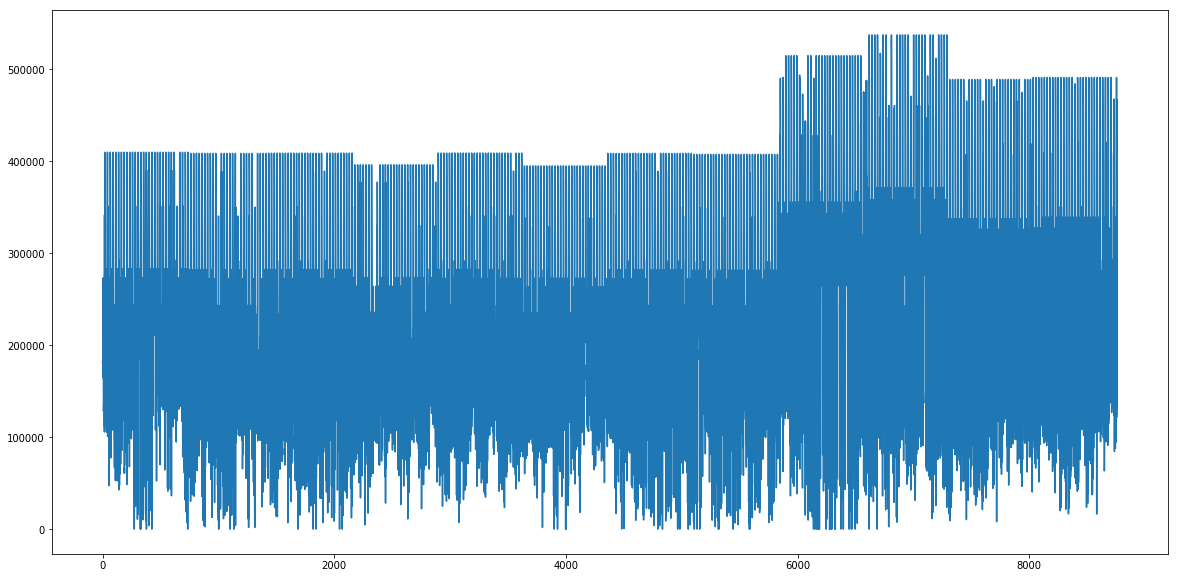

In [81]:
create_plot(RNG_df)